
# Testing Custom Mask R-CNN Model

In [1]:
#!pip install tensorflow==1.15.0
#!pip show tensorflow #.15.0
#!pip show keras #2.2.5
#!pip show h5py  #2.10.0

#!pip install scikit-image

In [23]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

ROOT_DIR = "C:/Users/Artyom/PycharmProjects/my_VKRR"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "C:/Users/Artyom/PycharmProjects/my_VKRR/logs/object20230514T0647/mask_rcnn_object_0030.h5"   # change it


In [24]:
class CustomConfig(Config):
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2

    STEPS_PER_EPOCH = 10

    DETECTION_MIN_CONFIDENCE = 0.9

In [25]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset/")
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [26]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "dirty")
        self.add_class("object", 2, "nope")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open(os.path.join(dataset_dir, f'{subset}.json')))
        
        # print(annotations1)
        annotations = list(annotations1.values())

        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            # print(a)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"dirty": 1,"nope": 2}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [27]:
TEST_MODE = "inference"
ROOT_DIR = "C:/Users/Artyom/PycharmProjects/my_VKRR/dataset"

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

CUSTOM_DIR = "C:/Users/Artyom/PycharmProjects/my_VKRR/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['nope']
numids [2]
objects: ['nope']
numids [2]
objects: ['dirty']
numids [1]
objects: ['dirty']
numids [1]
objects: ['dirty']
numids [1]
objects: ['dirty', 'dirty']
numids [1, 1]
objects: ['dirty']
numids [1]
objects: ['dirty', 'dirty', 'dirty']
numids [1, 1, 1]
objects: ['nope']
numids [2]
objects: ['nope']
numids [2]
objects: ['dirty']
numids [1]
objects: ['nope']
numids [2]
objects: ['nope']
numids [2]
Images: 13
Classes: ['BG', 'dirty', 'nope']


In [7]:
#!pip show tensorflow


In [28]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [29]:
weights_path = WEIGHTS_PATH
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:/Users/Artyom/PycharmProjects/my_VKRR/logs/object20230514T0647/mask_rcnn_object_0030.h5
Re-starting from epoch 30


In [10]:
image_id = random.choice(dataset.image_ids)
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

results = model.detect([image], verbose=1)

image id is : 168
image ID: object.grape_healthy (3).JPG (168) D:\python3.6.8_tensorflow_1.14_env\maskrcnn_leave_disease_detection\dataset\val\grape_healthy (3).JPG
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


# Предсказание на тестовых данных

1
Processing 1 images
image                    shape: (3000, 3000, 3)       min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[ 658 1379  741 1444]
 [1723 1621 1826 1709]
 [   0 1222 2984 1925]] [1 1 2]


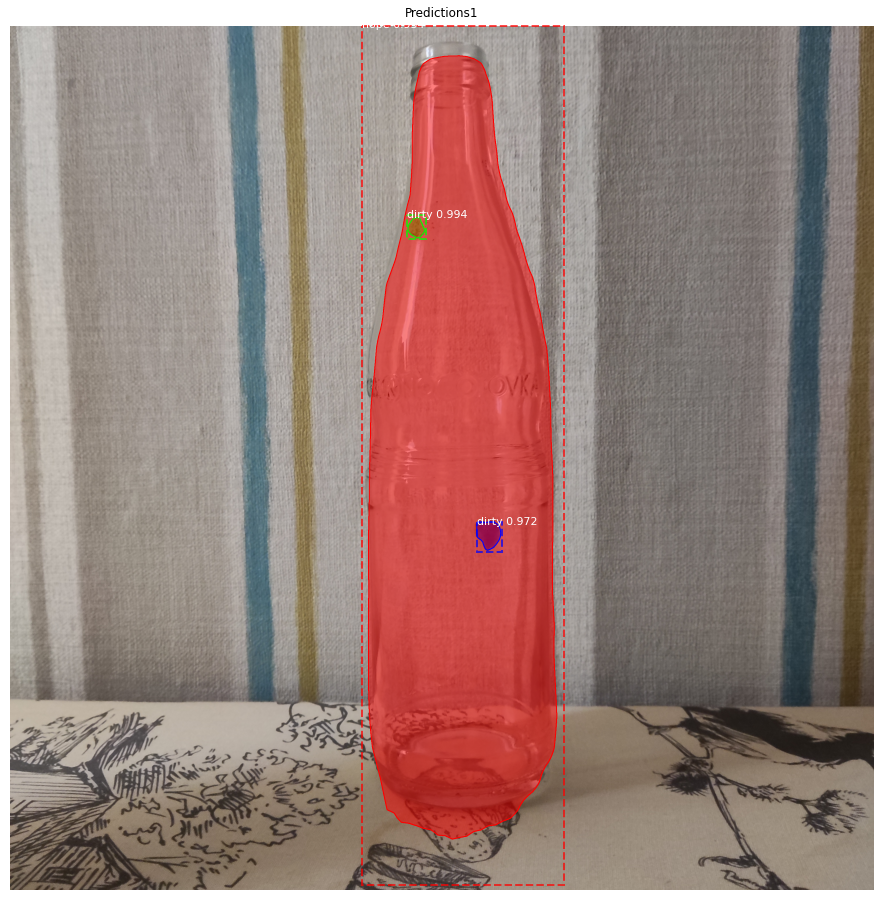

In [80]:
path_to_new_image = 'C:/Users/Artyom/PycharmProjects/my_VKRR/dataset/test.jpg'
image1 = mpimg.imread(path_to_new_image)

print(len([image1]))
results1 = model.detect([image1], verbose=1)

ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")
print(r1['rois'], r1['class_ids'])